# Interpolation


Parcels support a range of different interpolation methods for tracers, such as temperature. Here, we will show how these work, in an idealised example.

We first import the relevant modules


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import cm

from parcels import AdvectionRK4, FieldSet, JITParticle, ParticleSet, Variable

We create a small 2D grid where `P` is a tracer that we want to interpolate. In each grid cell, `P` has a random value between 0.1 and 1.1. We then set `P[1,1]` to `0`, which for Parcels specifies that this is a land cell


In [2]:
dims = [5, 4]
dx, dy = 1.0 / dims[0], 1.0 / dims[1]
dimensions = {
    "lat": np.linspace(0.0, 1.0, dims[0], dtype=np.float32),
    "lon": np.linspace(0.0, 1.0, dims[1], dtype=np.float32),
}
data = {
    "U": np.zeros(dims, dtype=np.float32),
    "V": np.zeros(dims, dtype=np.float32),
    "P": np.random.rand(dims[0], dims[1]) + 0.1,
}
data["P"][1, 1] = 0.0
fieldset = FieldSet.from_data(data, dimensions, mesh="flat")

We create a Particle class that can sample this field


In [3]:
class SampleParticle(JITParticle):
    p = Variable("p", dtype=np.float32)


def SampleP(particle, fieldset, time):
    particle.p = fieldset.P[time, particle.depth, particle.lat, particle.lon]

Now, we perform four different interpolation on `P`, which we can control by setting `fieldset.P.interp_method`. Note that this can always be done _after_ the `FieldSet` creation. We store the results of each interpolation method in an entry in the dictionary `pset`.


In [4]:
pset = {}
for p_interp in ["linear", "linear_invdist_land_tracer", "nearest", "cgrid_tracer"]:
    fieldset.P.interp_method = (
        p_interp  # setting the interpolation method for fieldset.P
    )

    xv, yv = np.meshgrid(np.linspace(0, 1, 8), np.linspace(0, 1, 8))
    pset[p_interp] = ParticleSet(
        fieldset, pclass=SampleParticle, lon=xv.flatten(), lat=yv.flatten()
    )
    pset[p_interp].execute(SampleP, endtime=1, dt=1)

INFO: Compiled ArraySampleParticleSampleP ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib5f0dd02408d62856f90e73b67d771e89_0.so
INFO: Compiled ArraySampleParticleSampleP ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/libc5ff6237848e532e5b37818859785562_0.so
INFO: Compiled ArraySampleParticleSampleP ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib51e05fe74791e950f5c617750c3c7bca_0.so
INFO: Compiled ArraySampleParticleSampleP ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/libf8a1b6b370814b16659481b2dae5ffb5_0.so


And then we can show each of the four interpolation methods, by plotting the interpolated values on the `Particle` locations (circles) on top of the `Field` values (background colors)


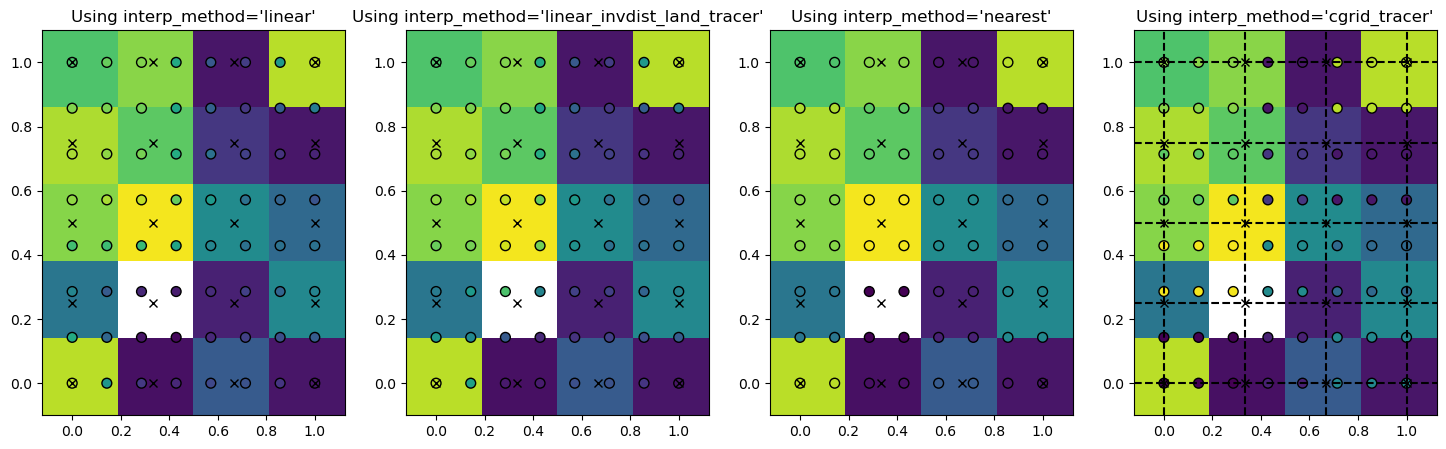

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
for i, p in enumerate(pset.keys()):
    data = fieldset.P.data[0, :, :]
    data[1, 1] = np.nan
    x = np.linspace(-dx / 2, 1 + dx / 2, dims[0] + 1)
    y = np.linspace(-dy / 2, 1 + dy / 2, dims[1] + 1)
    if p == "cgrid_tracer":
        for lat in fieldset.P.grid.lat:
            ax[i].axhline(lat, color="k", linestyle="--")
        for lon in fieldset.P.grid.lon:
            ax[i].axvline(lon, color="k", linestyle="--")
    ax[i].pcolormesh(y, x, data, vmin=0.1, vmax=1.1)
    ax[i].scatter(
        pset[p].lon, pset[p].lat, c=pset[p].p, edgecolors="k", s=50, vmin=0.1, vmax=1.1
    )
    xp, yp = np.meshgrid(fieldset.P.lon, fieldset.P.lat)
    ax[i].plot(xp, yp, "kx")
    ax[i].set_title(f"Using interp_method='{p}'")
plt.show()

The white box is here the 'land' point where the tracer is set to zero and the crosses are the locations of the grid points. As you see, the interpolated value is always equal to the field value if the particle is exactly on the grid point (circles on crosses).

For `interp_method='nearest'`, the particle values are the same for all particles in a grid cell. They are also the same for `interp_method='cgrid_tracer'`, but the grid cells have then shifted. That is because in a C-grid, the tracer grid cell is on the top-right corner (black dashed lines in right-most panel).

For `interp_method='linear_invdist_land_tracer'`, we see that values are the same as `interp_method='linear'` for grid cells that don't border the land point. For grid cells that do border the land cell, the `linear_invdist_land_tracer` interpolation method gives higher values, as also shown in the difference plot below


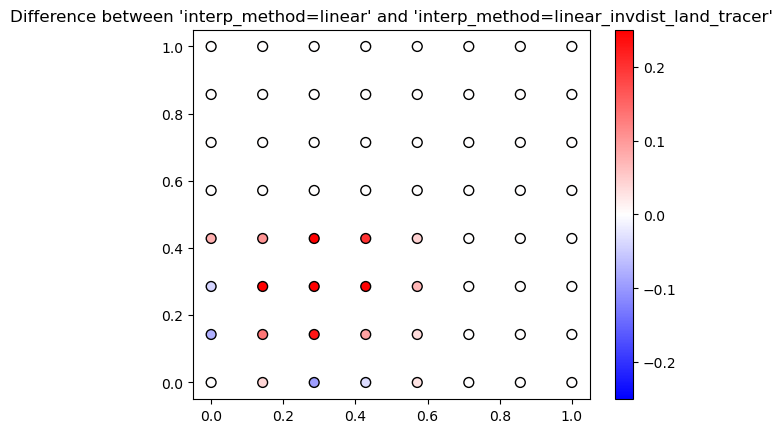

In [6]:
plt.scatter(
    pset["linear"].lon,
    pset["linear"].lat,
    c=pset["linear_invdist_land_tracer"].p - pset["linear"].p,
    edgecolors="k",
    s=50,
    cmap=cm.bwr,
    vmin=-0.25,
    vmax=0.25,
)
plt.colorbar()
plt.title(
    "Difference between 'interp_method=linear' and 'interp_method=linear_invdist_land_tracer'"
)
plt.show()

So in summary, Parcels has four different interpolation schemes for tracers:

1. `interp_method=linear`: compute linear interpolation
2. `interp_method=linear_invdist_land_tracer`: compute linear interpolation except near land (where field value is zero). In that case, inverse distance weighting interpolation is computed, weighting by squares of the distance.
3. `interp_method=nearest`: return nearest field value
4. `interp_method=cgrid_tracer`: return nearest field value supposing C cells


## Interpolation and sampling on time-varying Fields

Note that there is an important subtlety in Sampling a time-evolving Field. As noted in [this Issue](https://github.com/OceanParcels/parcels/issues/1122), interpolation of a Field only gives the correct answer when that field is interpolated at `time+particle.dt` _and_ the Sampling Kernel is concatenated _after_ the Advection Kernel.

Let's show how this works with a simple idealised Field `P` given by the equation


In [7]:
def calc_p(t, y, x):
    return 10 * t + x + 0.2 * y

Let's define a simple `FieldSet` with two timesteps, a 0.5 m/s zonal velocity and no meridional velocity.


In [8]:
dims = [2, 4, 5]
dimensions = {
    "lon": np.linspace(0.0, 1.0, dims[2], dtype=np.float32),
    "lat": np.linspace(0.0, 1.0, dims[1], dtype=np.float32),
    "time": np.arange(dims[0], dtype=np.float32),
}

p = np.zeros(dims, dtype=np.float32)
for i, x in enumerate(dimensions["lon"]):
    for j, y in enumerate(dimensions["lat"]):
        for n, t in enumerate(dimensions["time"]):
            p[n, j, i] = calc_p(t, y, x)

data = {
    "U": 0.5 * np.ones(dims, dtype=np.float32),
    "V": np.zeros(dims, dtype=np.float32),
    "P": p,
}
fieldset = FieldSet.from_data(data, dimensions, mesh="flat")

Now create four particles and a Sampling class so we can sample the Field `P`


In [9]:
xv, yv = np.meshgrid(np.arange(0, 1, 0.5), np.arange(0, 1, 0.5))


class SampleParticle(JITParticle):
    p = Variable("p", dtype=np.float32)


pset = ParticleSet(fieldset, pclass=SampleParticle, lon=xv.flatten(), lat=yv.flatten())

The key now is that we need to create a sampling Kernel where the Field `P` is sampled at `time+particle.dt` _and_ that we concatenate this kernel after the AdvectionRK4 Kernel


In [10]:
def SampleP(particle, fieldset, time):
    """offset sampling by dt"""
    particle.p = fieldset.P[
        time + particle.dt, particle.depth, particle.lat, particle.lon
    ]


kernels = AdvectionRK4 + pset.Kernel(
    SampleP
)  # Note that the order of concatenation matters here!

We can now run these kernels on the ParticleSet


In [11]:
pfile = pset.ParticleFile("interpolation_offset.zarr", outputdt=1)
pset.execute(kernels, endtime=1, dt=1, output_file=pfile)

INFO: Compiled ArraySampleParticleAdvectionRK4SampleP ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib31f1ffbeb60064af6d872afa1f6fc806_0.so


And we can check whether the `Particle.p` values indeed are consistent with the `calc_p()` values


In [12]:
for p in pset:
    assert np.isclose(p.p, calc_p(p.time, p.lat, p.lon))

And the same for the netcdf file (note that we need to convert `time` from nanoseconds to seconds)


In [13]:
ds = xr.open_zarr("interpolation_offset.zarr").isel(obs=1)
for i in range(len(ds["p"])):
    assert np.isclose(
        ds["p"].values[i],
        calc_p(
            float(ds["time"].values[i]) / 1e9, ds["lat"].values[i], ds["lon"].values[i]
        ),
    )

As a bit of background for why sampling needs to be done this way: the reason is that the particles are already moved within the AdvectionRK4 kernel, but the time is not updated yet until all concatenated kernels are completed.
